Here, you can evaluate the models on the datasets for the training lengths you have run in 4_run_paper_benchmark.py.

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [88]:
data_folder = "/home/dev/projects/data/"
benchmark_output_folder = "/home/dev/projects/data/outputs/benchmark/"
benchmark_results_folder = benchmark_output_folder + "results/"
image_format = "pdf" #png or pdf

In [ ]:
datasets = ["Cosmic1", "Cosmic2", "Cosmic3"]  +  [f'LP16_{x}' for x in range(1, 21)] + [f'LP17_{x}' for x in range(1, 31)]
forecast_signal = "load"
models = [ "SNaive24", "SNaive168", "SeasAvg", "AutoArima", "AutoETS", "LinearRegression",  "XGboost",  "LSTM"] #"TimesFM",
train_lengths = [168,336,720,2160,4320,6480]

Save aggregated (per model and train length) rmsse results separately.

In [90]:
metrics = pd.read_parquet(benchmark_results_folder + "all_results.parquet")
metrics = metrics[metrics["Model"].isin(models)]
metrics.replace({"AutoArima":"AutoSARIMA", "XGboost":"XGBoost", "LinearRegression":"LR"}, inplace=True)

In [91]:
metrics.Model.unique()

array(['SNaive24', 'SNaive168', 'SeasAvg', 'LR', 'XGBoost', 'TimesFM',
       'AutoETS', 'LSTM', 'AutoSARIMA'], dtype=object)

In [ ]:
numeric_metrics = metrics.drop(columns="Data")

agg_model_len = numeric_metrics.groupby(by=["Train Length", "Model"]).agg(['mean', 'std']).round(2)

agg_model_len.columns = ['_'.join(col).strip() for col in agg_model_len.columns.values]
agg_model_len['RMSSE'] = agg_model_len['RMSSE_mean'].astype(str) + " (" + agg_model_len['RMSSE_std'].astype(str) + ")"

agg_model_len.reset_index(inplace=True)

result_rmsse = agg_model_len

result_rmsse = result_rmsse.pivot(index='Train Length', columns='Model', values='RMSSE')
result_rmsse.reset_index(inplace=True)

def format_rmsse(value):
    if isinstance(value, str) and '(' in value:
        mean_part = value.split(' (')[0]  
        std_part = value.split(' (')[1][:-1]  
        return f"{float(mean_part):.2f} ({float(std_part):.2f})"  
    return value

result_rmsse = result_rmsse.applymap(format_rmsse)


result_rmsse.to_csv(benchmark_results_folder + "agg_train_len_results_rmsse_mean.csv", index=False)
result_rmsse


Model,Train Length,AutoETS,AutoSARIMA,LR,LSTM,SNaive168,SNaive24,SeasAvg,TimesFM,XGBoost
0,168,1.14 (0.85),0.93 (0.78),0.70 (0.38),2.14 (5.93),0.64 (0.57),0.80 (0.63),0.64 (0.57),0.60 (0.59),0.50 (0.38)
1,336,1.07 (0.73),0.83 (0.59),0.57 (0.39),1.84 (4.57),0.64 (0.57),0.80 (0.63),0.60 (0.53),0.53 (0.45),0.49 (0.38)
2,720,1.05 (0.70),0.77 (0.53),0.57 (0.39),1.49 (3.74),0.64 (0.57),0.80 (0.63),0.58 (0.51),0.48 (0.40),0.49 (0.38)
3,2160,1.06 (0.74),0.78 (0.56),0.54 (0.39),1.30 (3.08),0.64 (0.57),0.80 (0.63),0.58 (0.51),0.47 (0.39),0.47 (0.37)
4,4320,1.06 (0.76),0.79 (0.57),0.54 (0.39),1.10 (2.16),0.64 (0.57),0.80 (0.63),0.59 (0.52),1.16 (0.80),0.48 (0.38)
5,6480,1.05 (0.76),0.79 (0.57),0.53 (0.41),1.05 (2.19),0.65 (0.57),0.80 (0.63),0.58 (0.52),1.83 (1.35),0.51 (0.41)


Plot the distributions of rmsse over the datasets per training length and model.

In [93]:
agg_model_len_data = metrics.groupby(by=["Train Length", "Model", "Data"]).median(numeric_only=True)
agg_model_len_data.reset_index(inplace=True)

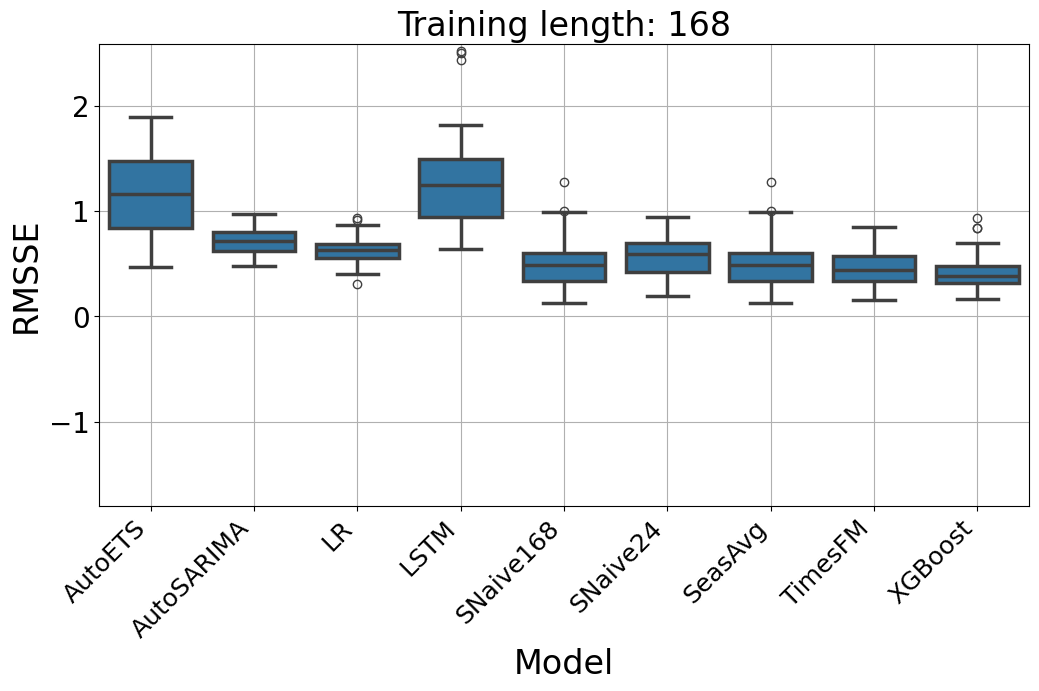

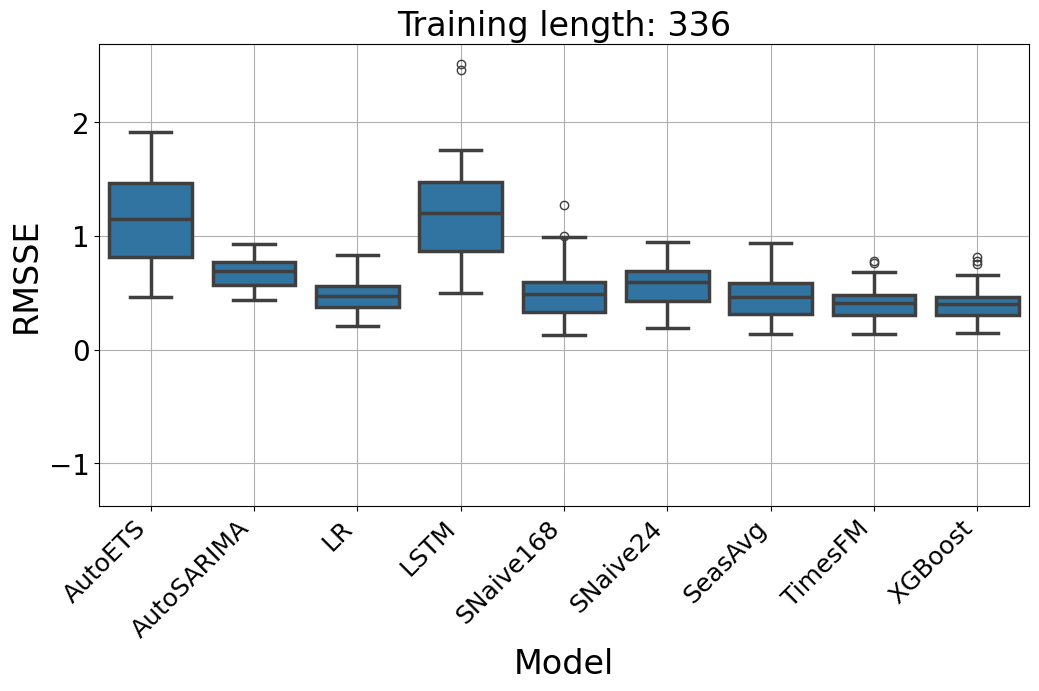

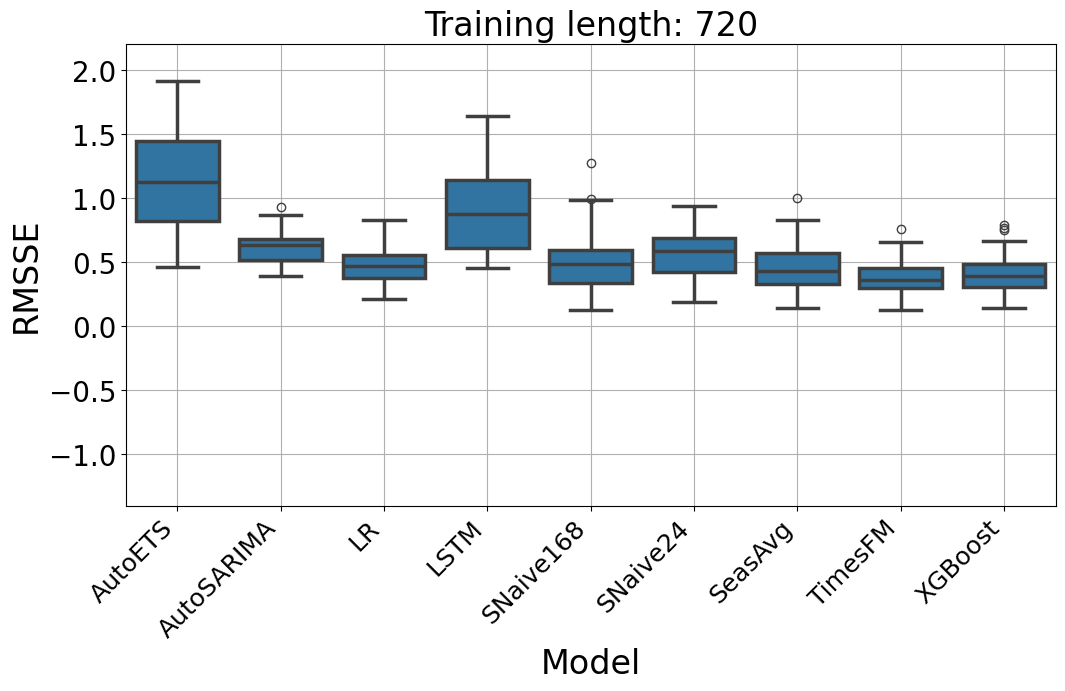

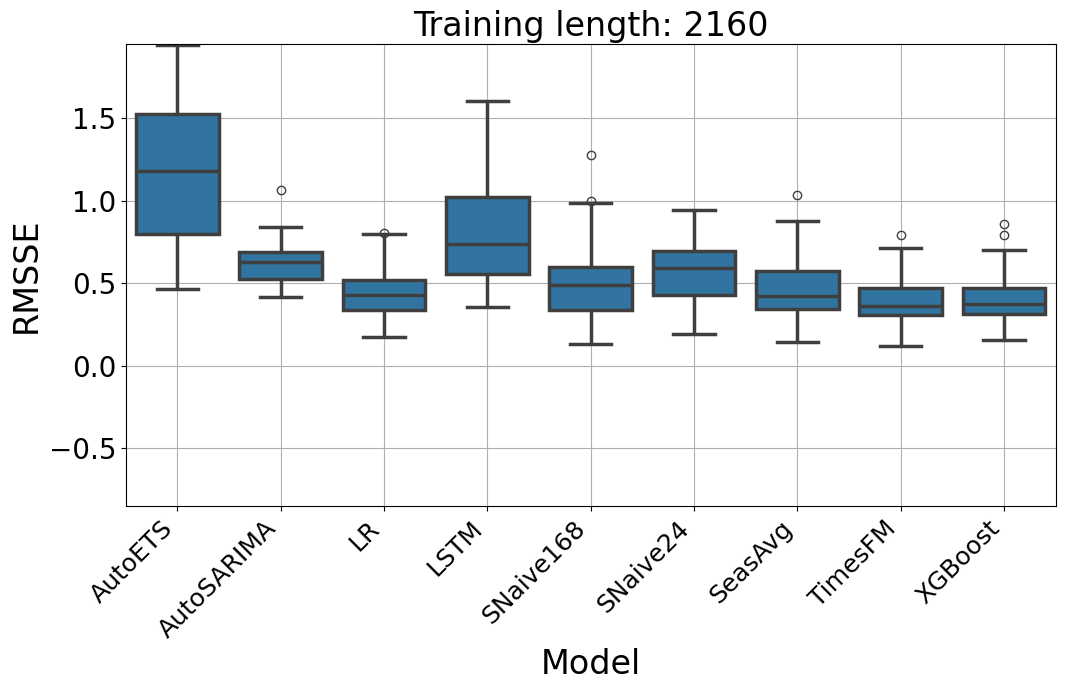

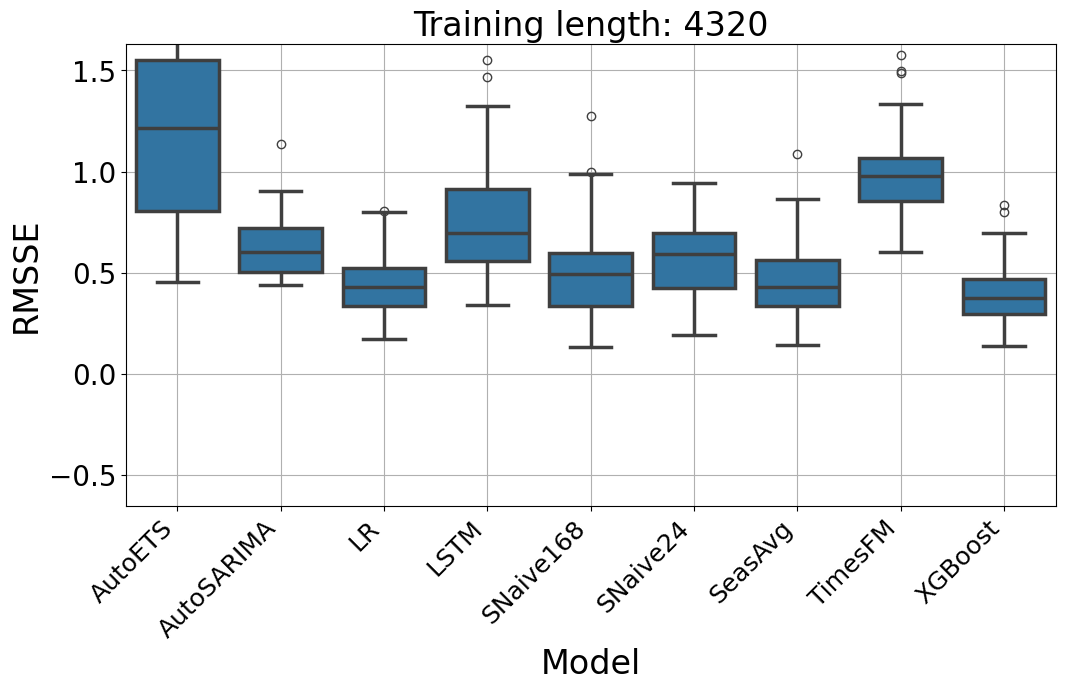

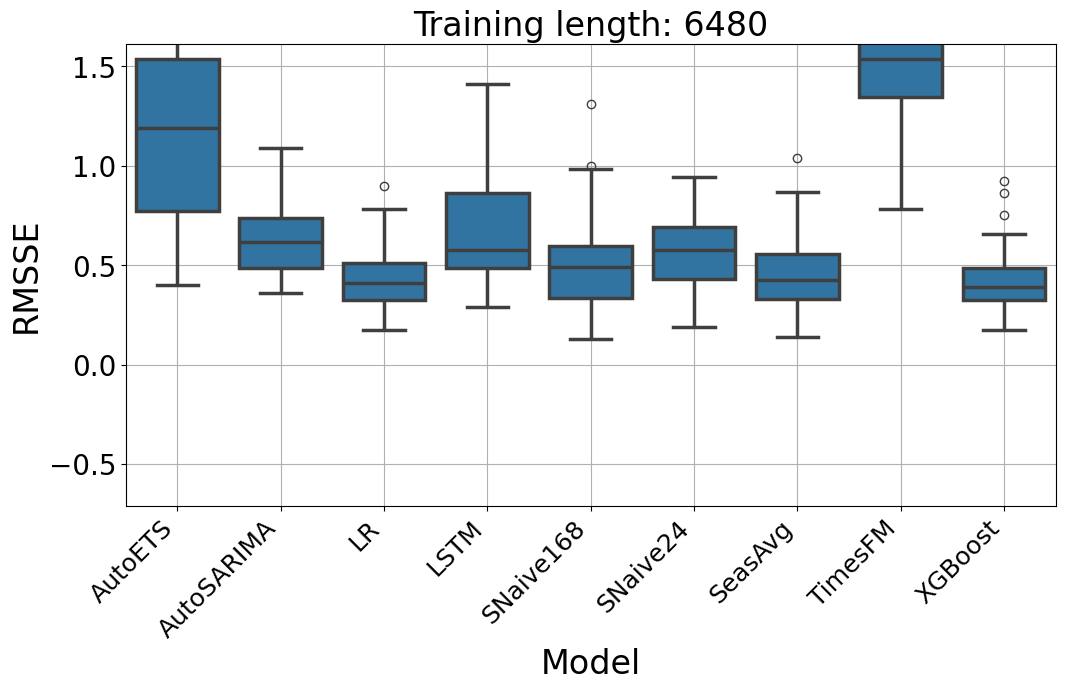

In [94]:
metrics_melted = agg_model_len_data.melt(id_vars=['Model', 'Train Length', 'Data'], 
                                           value_vars=['RMSSE'], 
                                           var_name='Metric', 
                                           value_name='Value')

train_lengths_unique = metrics_melted['Train Length'].unique()

for train_len in train_lengths_unique:
    data_for_train_len = metrics_melted[metrics_melted['Train Length'] == train_len]

    # Plot RMSSE
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Model', y='Value', data=data_for_train_len[data_for_train_len['Metric'] == 'RMSSE'], linewidth=2.5)
    plt.ylabel('RMSSE', fontsize=24)
    plt.xlabel('Model', fontsize=24)
    plt.title(f"Training length: {train_len}", fontsize=24)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=18)
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')

    lstm_rmsse = data_for_train_len[data_for_train_len['Model'] == 'LSTM']['Value']
    q3_rmsse = lstm_rmsse.quantile(0.75)
    q1_rmsse = lstm_rmsse.quantile(0.25)
    iqr_rmsse = q3_rmsse - q1_rmsse
    upper_limit_rmsse = q3_rmsse + 2 * iqr_rmsse
    plt.ylim(top=upper_limit_rmsse)
    
    plt.savefig(f'{benchmark_results_folder}distr_train_len_{train_len}_RMSSE.{image_format}', bbox_inches='tight')
    plt.show()

Plot the mean (over datasets) ranks (rmsse) of the models for the different training lengths.

In [95]:
df = agg_model_len_data

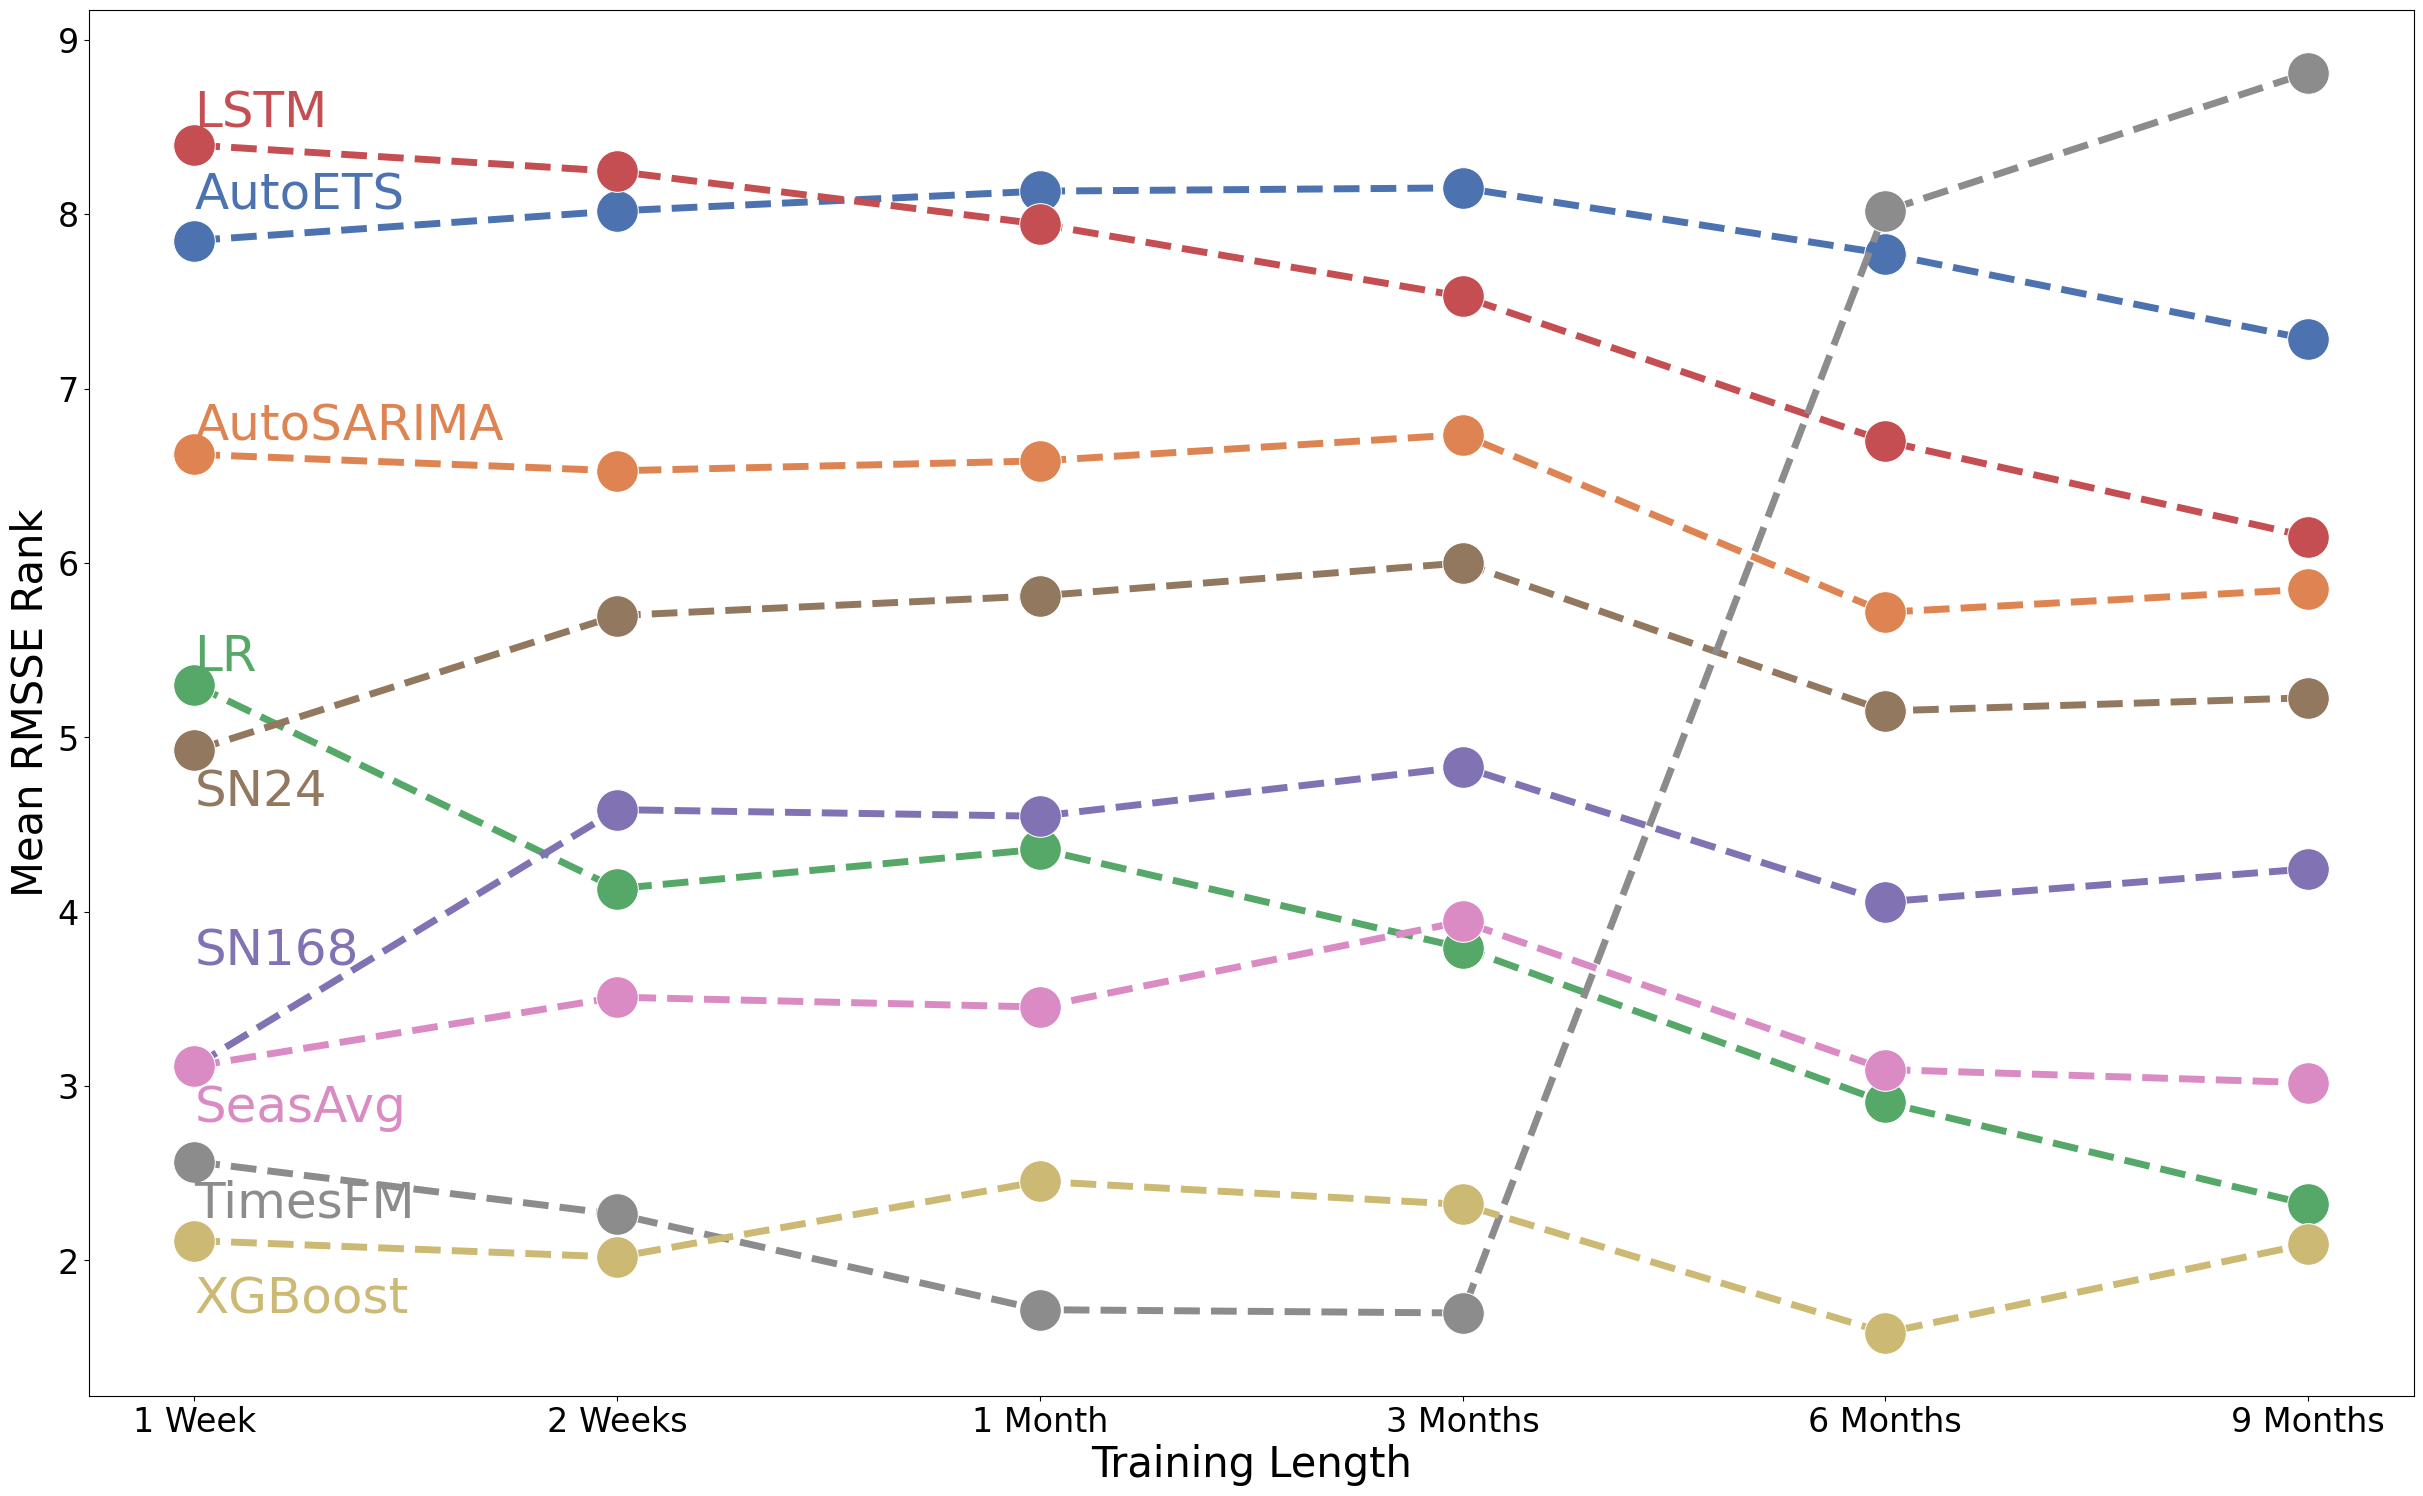

In [96]:
# Calculate mean ranks of each model for each training length
length_mapping = {
    168: '1 Week',
    336: '2 Weeks',
    720: '1 Month',
    2160: '3 Months',
    4320: '6 Months',
    6480: '9 Months'
}

df.replace({"SNaive24":"SN24", "SNaive168":"SN168", "LinearRegression":"LR"}, inplace=True)
df['Train Length'] = df['Train Length'].replace(length_mapping)
df['Train Length'] = pd.Categorical(df['Train Length'], 
                                     categories=['1 Week', '2 Weeks', '1 Month', 
                                                 '3 Months', '6 Months', '9 Months'], 
                                     ordered=True)

df['RMSSE_Rank'] = df.groupby(['Train Length', 'Data'])['RMSSE'].rank(method='min')

mean_ranks = df.groupby(['Train Length', 'Model']).agg({
    'RMSSE_Rank': 'mean',
}).reset_index()

mean_ranks.columns = ['Train Length', 'Model', 'Mean_RMSSE_Rank']


plt.figure(figsize=(30, 18)) 
palette = sns.color_palette("deep", n_colors=mean_ranks['Model'].nunique())  

for i, model in enumerate(mean_ranks['Model'].unique()):
    subset = mean_ranks[mean_ranks['Model'] == model]
    sns.lineplot(data=subset, x='Train Length', y='Mean_RMSSE_Rank',linestyle='--', marker='o', linewidth=5, markersize=30, color=palette[i])

    if (model == "AutoSARIMA"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] + 0.3, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model == "AutoETS"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] + 0.4, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model == "LR"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] +0.3, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model == "XGBoost"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] - 0.2, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model == "SeasAvg"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] -0.1, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model=="SN24"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] -0.1 , model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model=="SN168"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] +0.8, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    elif(model=="TimesFM"):
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] -0.1, model, fontsize=36, 
                 verticalalignment='top', horizontalalignment='left', color=palette[i])
    else:
        plt.text(subset['Train Length'].iloc[0], subset['Mean_RMSSE_Rank'].iloc[0] +0.1  , model, fontsize=36, 
                 verticalalignment='baseline' , horizontalalignment='left', color=palette[i])

plt.xlabel('Training Length', fontsize=30)
plt.ylabel('Mean RMSSE Rank', fontsize=30)
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)


plt.savefig(f'{benchmark_results_folder}rmsse_ranks.{image_format}', bbox_inches='tight')
plt.show()

TimesFM provides fundamentally different forecasts for the same rolling origin, depending on the input length.

In [97]:
timesfm_6480 = pd.read_parquet(f"{benchmark_output_folder}LP17_1/train_6480/TimesFM/TimesFM_2017-12-17 00:00:00_forecast.parquet")
timesfm_6480.drop(columns=["item_id", "start_date", "fcst_step"], inplace=True)
timesfm_6480.rename(columns={"sample_fcst0":"6480"}, inplace=True)
timesfm_2160 = pd.read_parquet(f"{benchmark_output_folder}LP17_1/train_2160/TimesFM/TimesFM_2017-12-17 00:00:00_forecast.parquet")
timesfm_2160.drop(columns=["item_id", "start_date", "fcst_step"], inplace=True)
timesfm_2160.rename(columns={"sample_fcst0":"2160"}, inplace=True)
timesfm_fcst = timesfm_6480.merge(timesfm_2160, on=["fcst_step_date"])
timesfm_fcst.rename(columns={"fcst_step_date":"date"}, inplace=True)
timesfm_fcst.date = timesfm_fcst.date.dt.tz_localize("UTC")
real = pd.read_parquet(f"{data_folder}processed/LP17_1/processed.parquet")
timesfm_fcst_vs_truth = timesfm_fcst.merge(real[["date", "power"]], on="date")
timesfm_fcst_vs_truth = pd.concat([timesfm_fcst_vs_truth, real[["date", "power"]].loc[(real.date >= "2017-12-01")&(real.date < "2017-12-17")]])
timesfm_fcst_vs_truth.rename(columns={"power":"truth"}, inplace=True)
timesfm_fcst_vs_truth.reset_index(drop=True, inplace=True)
timesfm_fcst_vs_truth.sort_values(by="date", inplace=True)
timesfm_fcst_vs_truth

,date,6480,2160,truth
24,2017-12-01 00:00:00+00:00,NaN,NaN,5.04250
25,2017-12-01 01:00:00+00:00,NaN,NaN,3.82125
26,2017-12-01 02:00:00+00:00,NaN,NaN,3.77625
27,2017-12-01 03:00:00+00:00,NaN,NaN,3.18875
28,2017-12-01 04:00:00+00:00,NaN,NaN,3.13375
...,...,...,...,...
19,2017-12-17 19:00:00+00:00,3.804876,5.334583,4.91000
20,2017-12-17 20:00:00+00:00,4.940629,5.430719,5.35000
21,2017-12-17 21:00:00+00:00,2.936577,5.215759,4.72125
22,2017-12-17 22:00:00+00:00,1.838925,4.331268,3.57375


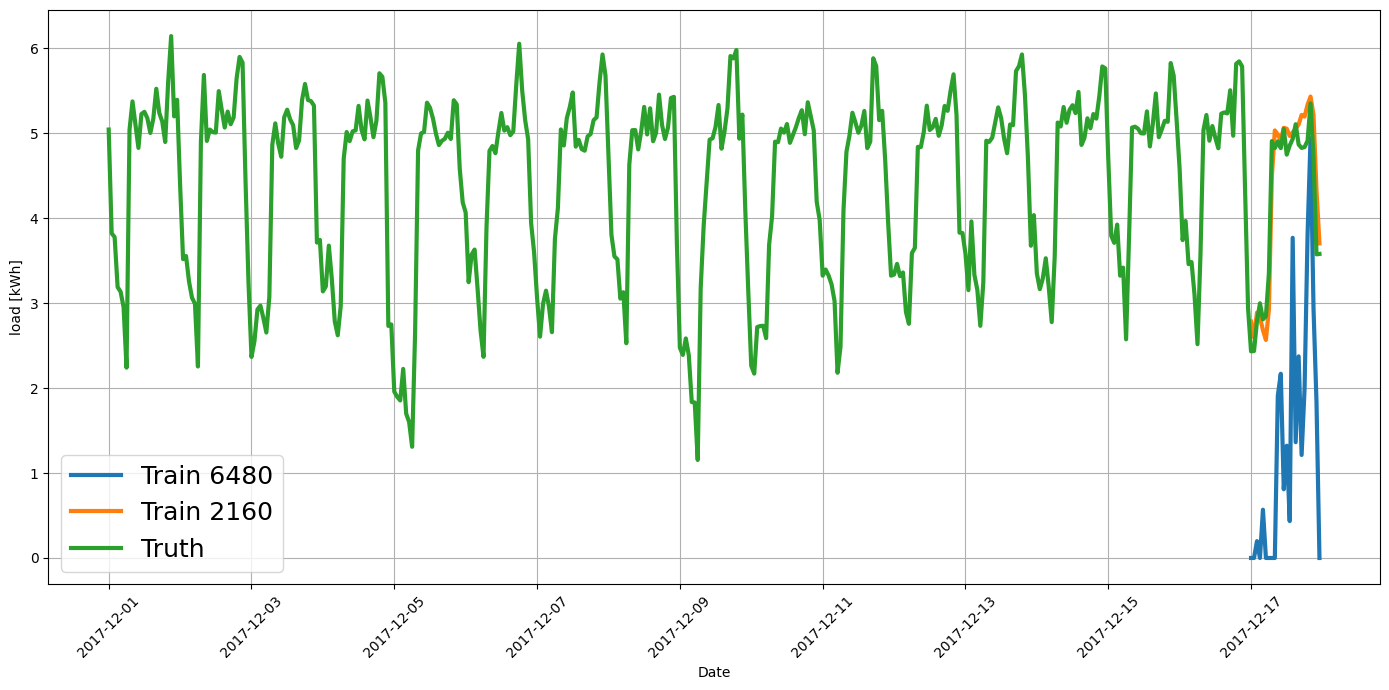

In [98]:
df = timesfm_fcst_vs_truth
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['6480'], label='Train 6480', linewidth=3)
plt.plot(df['date'], df['2160'], label='Train 2160', linewidth=3)
plt.plot(df['date'], df['truth'], label='Truth', linewidth=3)

plt.xlabel('Date')
plt.ylabel('load [kWh]')
plt.xticks(rotation=45)

plt.legend(fontsize=18)  

plt.grid()
plt.tight_layout()
plt.savefig(f"{benchmark_results_folder}TimesFM_performance_variance.{image_format}")
plt.show()

Forecasting the last two weeks of a year is generally a tricky task, due to holidays and vacations. 

In [99]:
sn_24 = pd.read_parquet(f"{benchmark_output_folder}LP16_5/train_168/SeasNaive24/SeasNaivePredictor_2016-12-30 00:00:00_forecast.parquet")
sn_24.drop(columns=["item_id", "start_date", "fcst_step"], inplace=True)
sn_24.rename(columns={"sample_fcst0":"SNaive24"}, inplace=True)
sn_168 = pd.read_parquet(f"{benchmark_output_folder}LP16_5/train_168/SeasNaive168/SeasNaivePredictor_2016-12-30 00:00:00_forecast.parquet")
sn_168.drop(columns=["item_id", "start_date", "fcst_step"], inplace=True)
sn_168.rename(columns={"sample_fcst0":"SNaive168"}, inplace=True)
sn_fcst = sn_24.merge(sn_168, on=["fcst_step_date"])
sn_fcst.rename(columns={"fcst_step_date":"date"}, inplace=True)
sn_fcst.date = sn_fcst.date.dt.tz_localize("UTC")
real = pd.read_parquet(f"{data_folder}processed/LP16_5/processed.parquet")
sn_fcst_vs_truth = sn_fcst.merge(real[["date", "power"]], on="date")
sn_fcst_vs_truth = pd.concat([sn_fcst_vs_truth, real[["date", "power"]].loc[(real.date >= "2016-12-15")&(real.date < "2016-12-30")]])
sn_fcst_vs_truth.rename(columns={"power":"truth"}, inplace=True)
sn_fcst_vs_truth.reset_index(drop=True, inplace=True)
sn_fcst_vs_truth.sort_values(by="date", inplace=True)
sn_fcst_vs_truth

,date,SNaive24,SNaive168,truth
24,2016-12-15 00:00:00+00:00,NaN,NaN,14.88
25,2016-12-15 01:00:00+00:00,NaN,NaN,14.72
26,2016-12-15 02:00:00+00:00,NaN,NaN,14.80
27,2016-12-15 03:00:00+00:00,NaN,NaN,14.72
28,2016-12-15 04:00:00+00:00,NaN,NaN,16.40
...,...,...,...,...
19,2016-12-30 19:00:00+00:00,20.08,28.00,20.32
20,2016-12-30 20:00:00+00:00,20.24,20.08,20.32
21,2016-12-30 21:00:00+00:00,14.96,14.88,14.96
22,2016-12-30 22:00:00+00:00,13.60,13.28,13.52


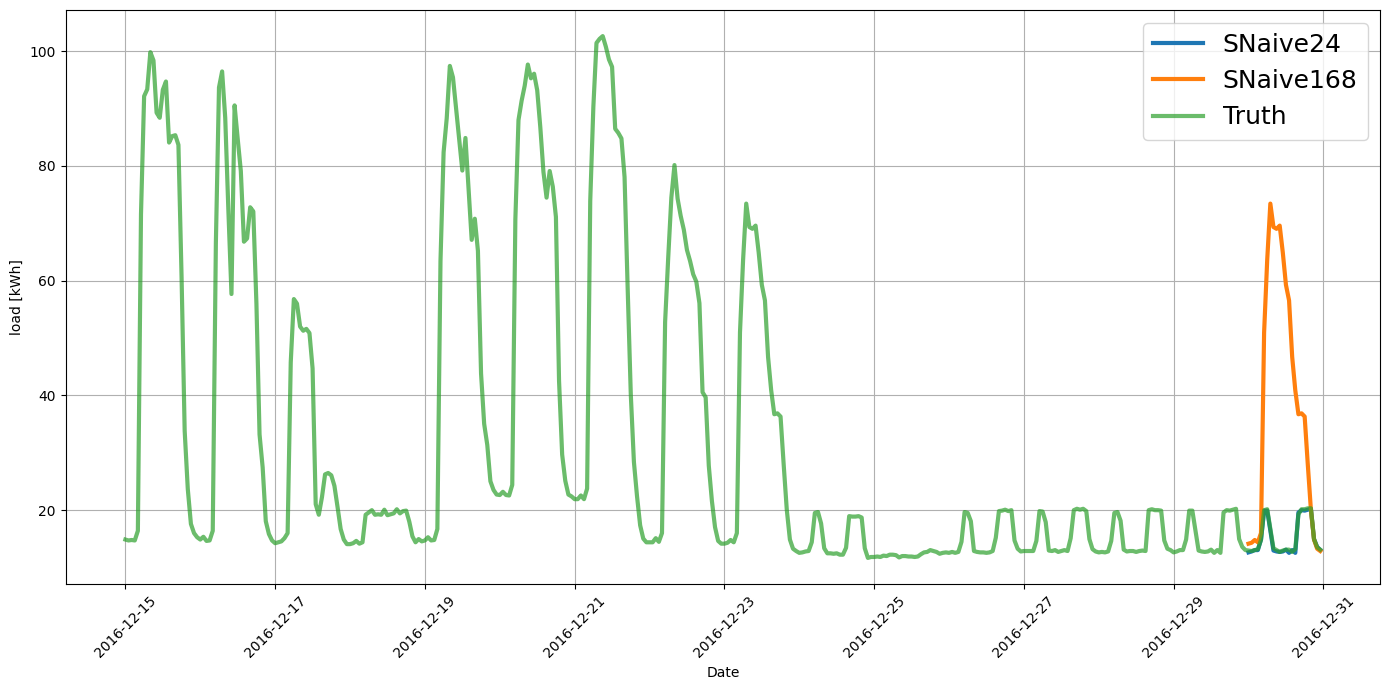

In [100]:
df = sn_fcst_vs_truth
df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['SNaive24'], label='SNaive24', linewidth=3) 
plt.plot(df['date'], df['SNaive168'], label='SNaive168', linewidth=3) 
plt.plot(df['date'], df['truth'], label='Truth', linewidth=3, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('load [kWh]')
plt.xticks(rotation=45)

plt.legend(fontsize=18)  

plt.grid()
plt.tight_layout()
plt.savefig(f"{benchmark_results_folder}Last_day_of_year.{image_format}")
plt.show()